## Задание
* Разработать RF-классификатор (Random Forest) для набора данных, указанного в варианте методических указаний (для задания 1).
* Разбить выборку на обучающую и тестовую.
* Обучить, проверить качество классификатора на обучающей и тестовой выборках: рассчитать общую точность, Recall, Precision, F1-measure.
* Рассмотреть различное число ближайших соседей, различные метрики для вычисления расстояний между объектами, различные правила голосования. Перебор по сетке (grid search).
* Выбрать лучший классификатор.
* Выполнить визуализацию с помощью t-sne и UMAP (при различных сочетаниях значений их параметров): изобразить объекты разных классов разным цветом (разным маркерами).
* Сделать рисунки разбиения на классы на основе выборок с известными метками классов и рисунки разбиения на классы с метками выставленными классификатором.

## Подготовка данных
Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
%matplotlib inline

Загружаем и подготавливаем датасет.

In [2]:
data = pd.read_csv('./Data/hepatitis.data', index_col=False, names=['Class', 'Age', 'Sex', 'Steroid', 'Antivrals', 'Fatigue', 'Malaise', 'Anorexia',
                                                                    'Liver big', 'Liver firm', 'Spleen palpable', 'Spiders', 'Ascites', 'Varices', 'Bilirubin', 'Alk phosphate', 'Sgot', 'Albumin', 'Protime', 'Histology'])

x = data.drop(['Class'], axis=1)
y = data['Class']

x = x.replace('?', np.nan)
y = y.replace(1, 0)
y = y.replace(2, 1)
for (colName, colData) in x.iteritems():
    x[colName] = x[colName].astype(float)
    x[colName] = x[colName].fillna(x[colName].mean())
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

Разбиваем выборку на обучающую и тестовую в соотношении.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Задаем параметры для **gridSearch**

In [4]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
params = {
    'rf__n_estimators': [120, 140],
    'rf__max_depth': [30, 50],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [3, 5],
}

## Перебор параметров по сетке
С помощью модуля gridsearch производим подбор наилучших параметров для нашего алгоритма.

In [5]:
RF_gs = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=3)
RF_gs.fit(x_train, y_train)
print(RF_gs.best_params_)
print(RF_gs.best_score_)
print(RF_gs.best_estimator_)

{'rf__max_depth': 30, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 3, 'rf__n_estimators': 120}
0.8981937602627258
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score=False, random_state=None,

In [6]:
RF_gs.score(x_train, y_train)

0.990695128626163

In [7]:
RF_gs.score(x_test, y_test)

0.8535353535353535

In [8]:
RF = RF_gs.best_estimator_
RF.fit(x_train, y_train)

# Предсказание модели
y_pred = RF.predict(x_test)

# Точность Random Forest
acc_rf = metrics.accuracy_score(y_pred, y_test, normalize=True)

print('Точность Random Forest:', acc_rf)

Точность Random Forest: 0.8297872340425532


In [9]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      0.27      0.43        11
           1       0.82      1.00      0.90        36

    accuracy                           0.83        47
   macro avg       0.91      0.64      0.66        47
weighted avg       0.86      0.83      0.79        47



In [10]:
def draw_confusion_matrix(test, pred):
    cm = confusion_matrix(test, pred)
    df_cm = pd.DataFrame(cm, columns=np.unique(test), index=np.unique(test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(13, 13))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,
                annot_kws={"size": 16})  # font size

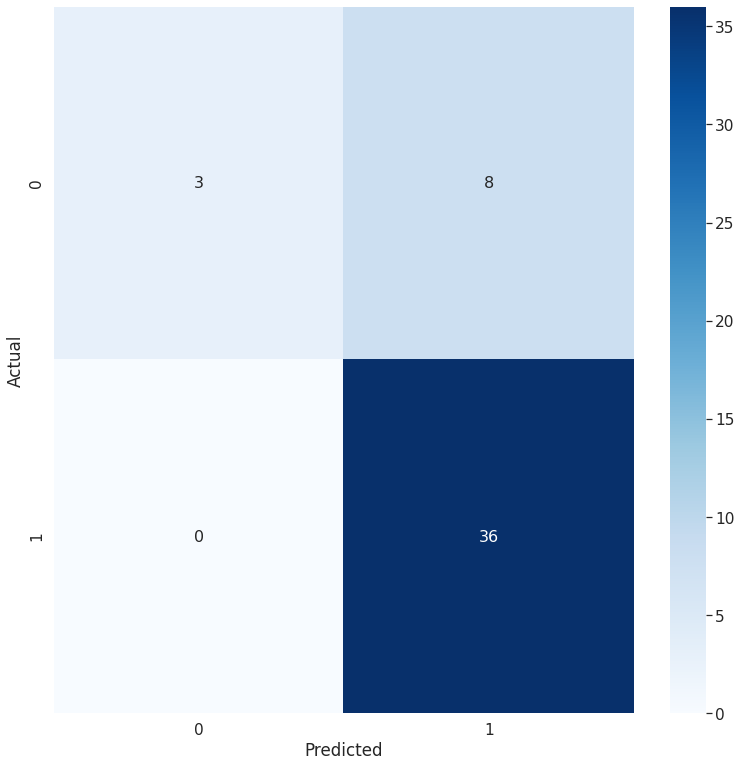

In [11]:
draw_confusion_matrix(y_test, y_pred)

In [12]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.7896656534954407

Зависимость общей точности модели от гиперпараметров

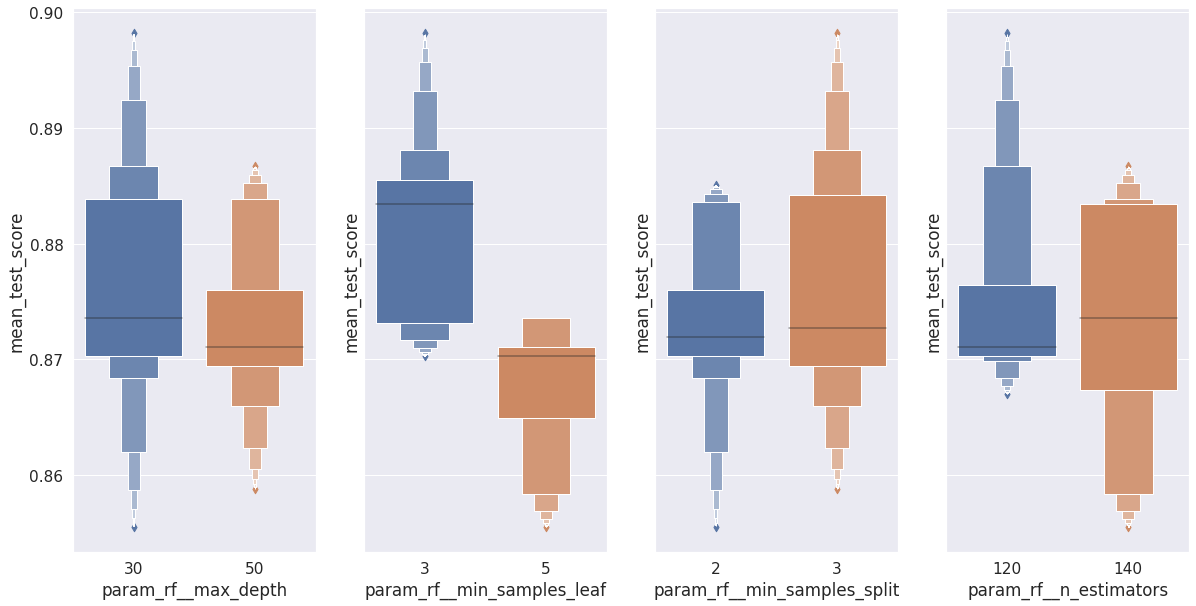

In [13]:
grsh_results = pd.DataFrame(data=RF_gs.cv_results_)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 10))
sns.boxenplot(x=grsh_results['param_rf__max_depth'],
              y=grsh_results['mean_test_score'], ax=axs[0])
sns.boxenplot(x=grsh_results['param_rf__min_samples_leaf'],
              y=grsh_results['mean_test_score'], ax=axs[1])
sns.boxenplot(x=grsh_results['param_rf__min_samples_split'],
              y=grsh_results['mean_test_score'], ax=axs[2])
sns.boxenplot(x=grsh_results['param_rf__n_estimators'],
              y=grsh_results['mean_test_score'], ax=axs[3])

## T-SNE
### Perplexity

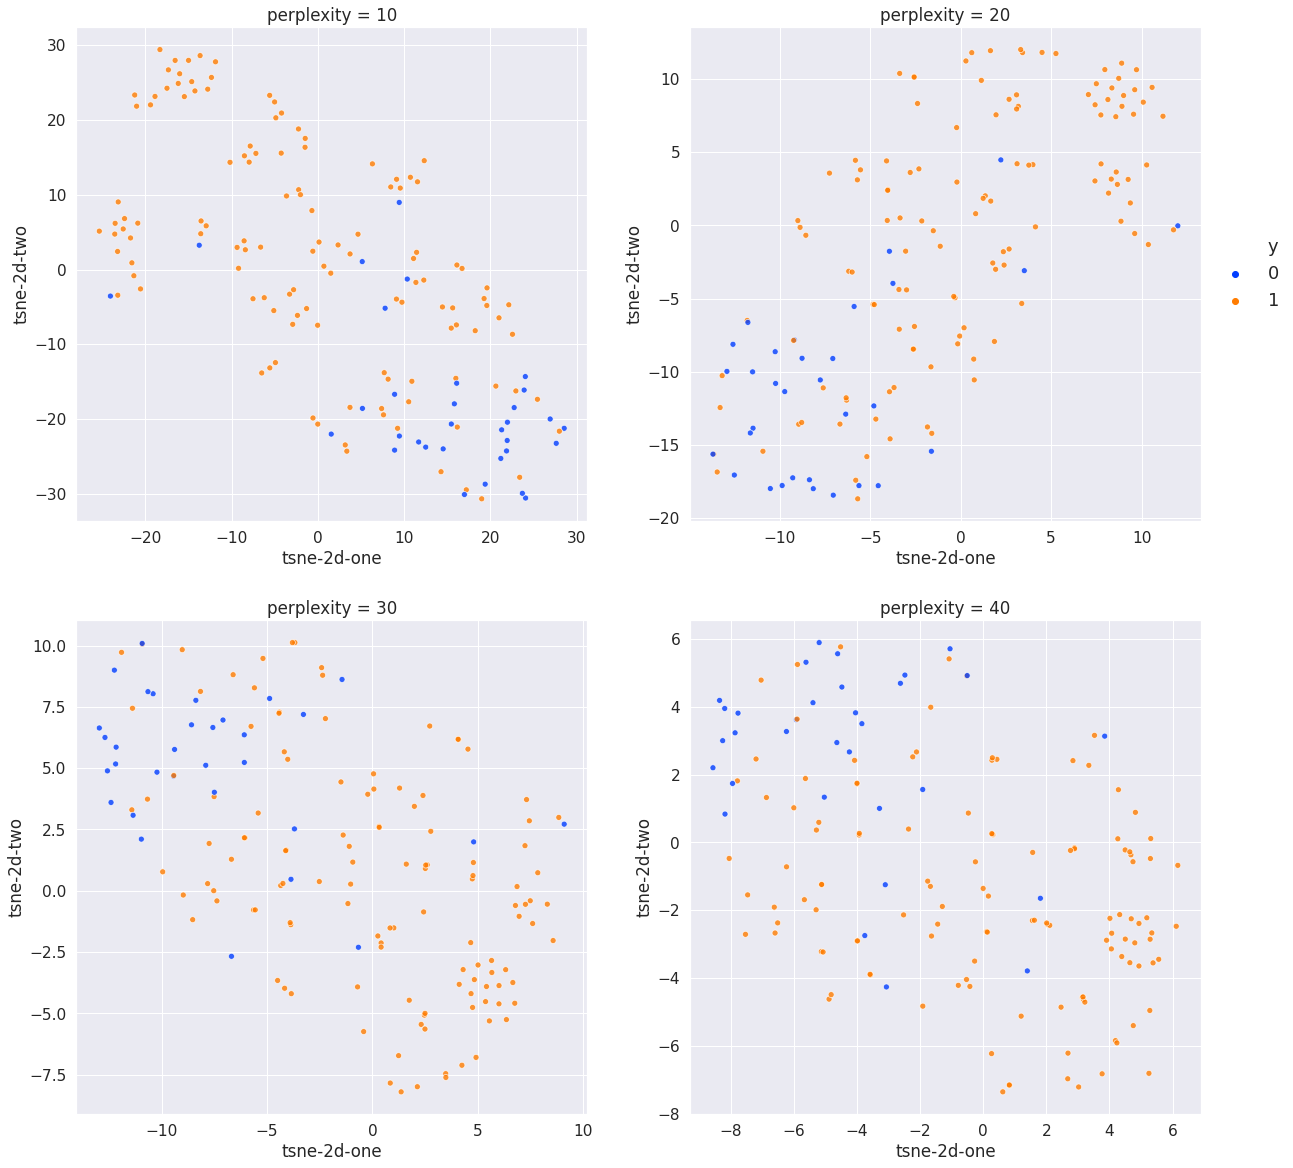

In [14]:
p = [10, 20, 30, 40]
arr = []
for elem in p:
    x_embedded = TSNE(n_components=2, perplexity=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(25, 20))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("perplexity = 10")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(2, 2, 2)
ax2.set_title("perplexity = 20")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(2, 2, 3)
ax3.set_title("perplexity = 30")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(2, 2, 4)
ax4.set_title("perplexity = 40")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

### Early exaggeration

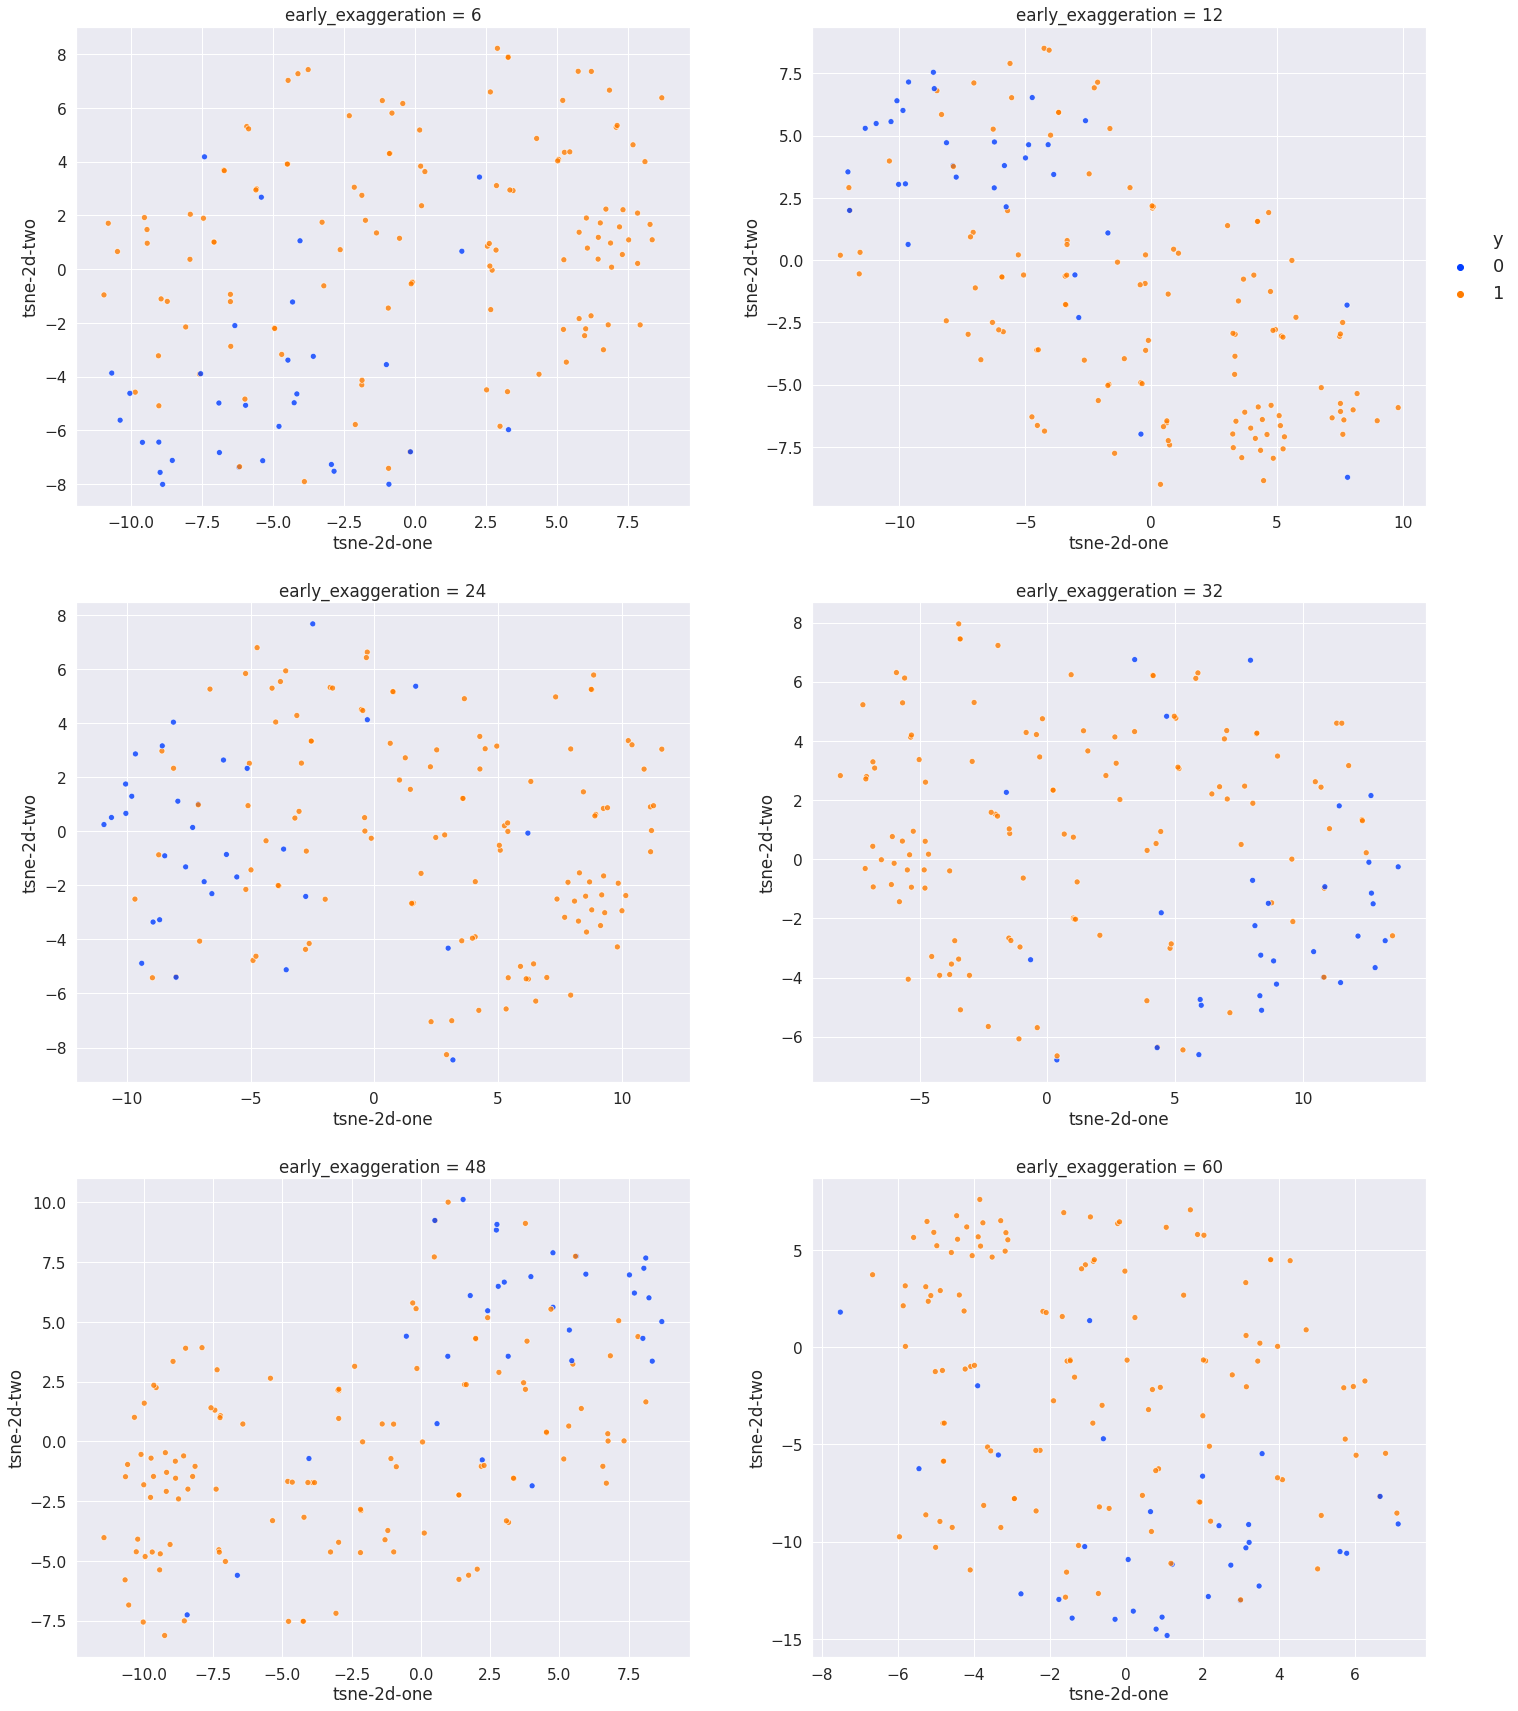

In [15]:
ee = [6, 12, 24, 32, 48, 60]
arr = []
for elem in ee:
    x_embedded = TSNE(n_components=2, early_exaggeration=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("early_exaggeration = 6")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("early_exaggeration = 12")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("early_exaggeration = 24")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("early_exaggeration = 32")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("early_exaggeration = 48")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("early_exaggeration = 60")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Построение графика с комбинацией различных параметров алгоритма t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155 samples in 0.000s...
[t-SNE] Computed neighbors for 155 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 155 / 155
[t-SNE] Mean sigma: 0.898091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.812538
[t-SNE] KL divergence after 1050 iterations: 0.433188


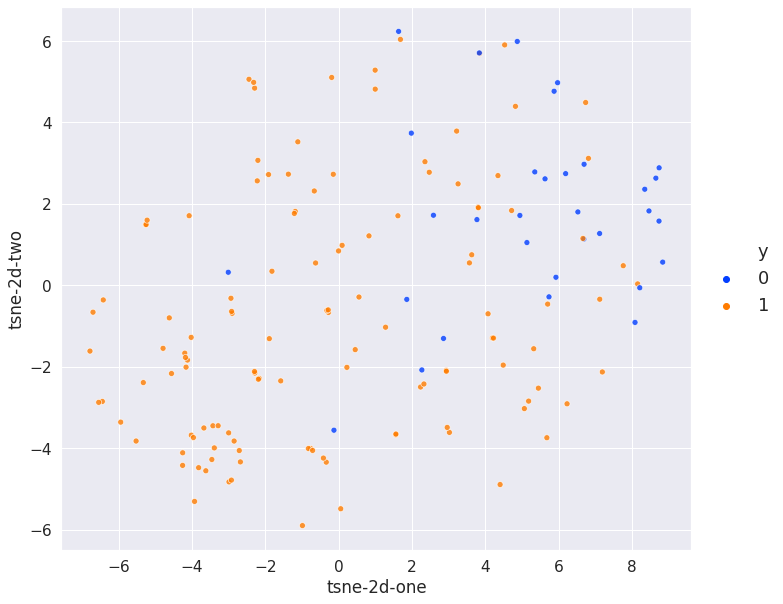

In [16]:
x_embedded = TSNE(n_components=2, verbose=1, perplexity=40,
                  early_exaggeration=12, metric='euclidean',
                  learning_rate=100, n_iter=2000).fit_transform(x)

x_df = pd.DataFrame()
x_df['tsne-2d-one'] = x_embedded[:, 0]
x_df['tsne-2d-two'] = x_embedded[:, 1]
x_df['y'] = y

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=x_df, legend="full", alpha=0.8)
plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

## UMAP
### Nearest neighbours

/mnt/c/Users/User/My projects/Python/IMIZ/venv/lib/python3.6/site-packages/umap/umap_.py:1383: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


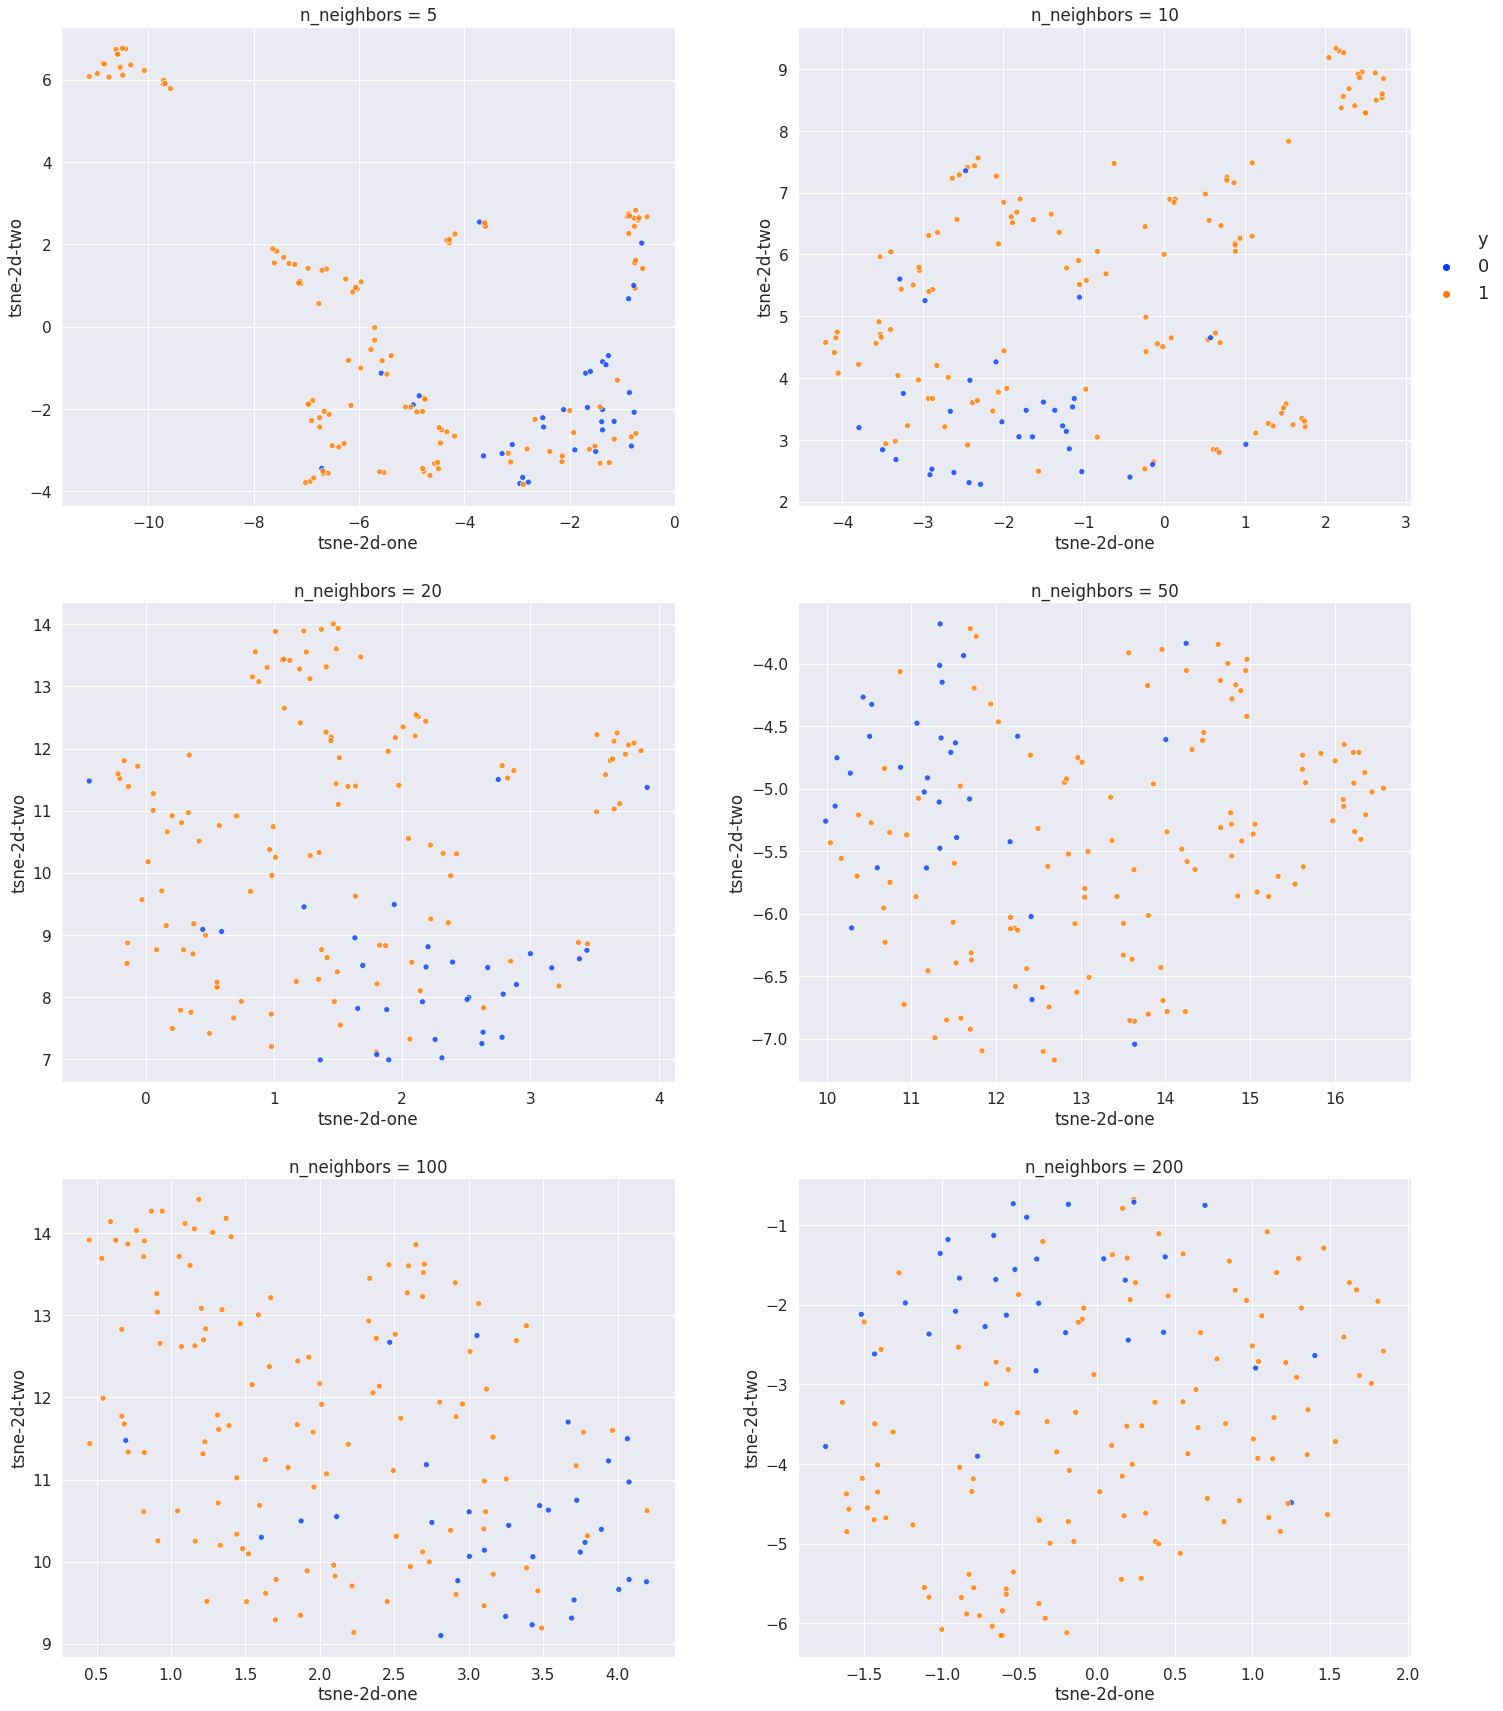

In [17]:
nn = [5, 10, 20, 50, 100, 200]
arr = []
for elem in nn:
    x_embedded = umap.UMAP(n_components=2, n_neighbors=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("n_neighbors = 5")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("n_neighbors = 10")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("n_neighbors = 20")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("n_neighbors = 50")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("n_neighbors = 100")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("n_neighbors = 200")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Minimal distance

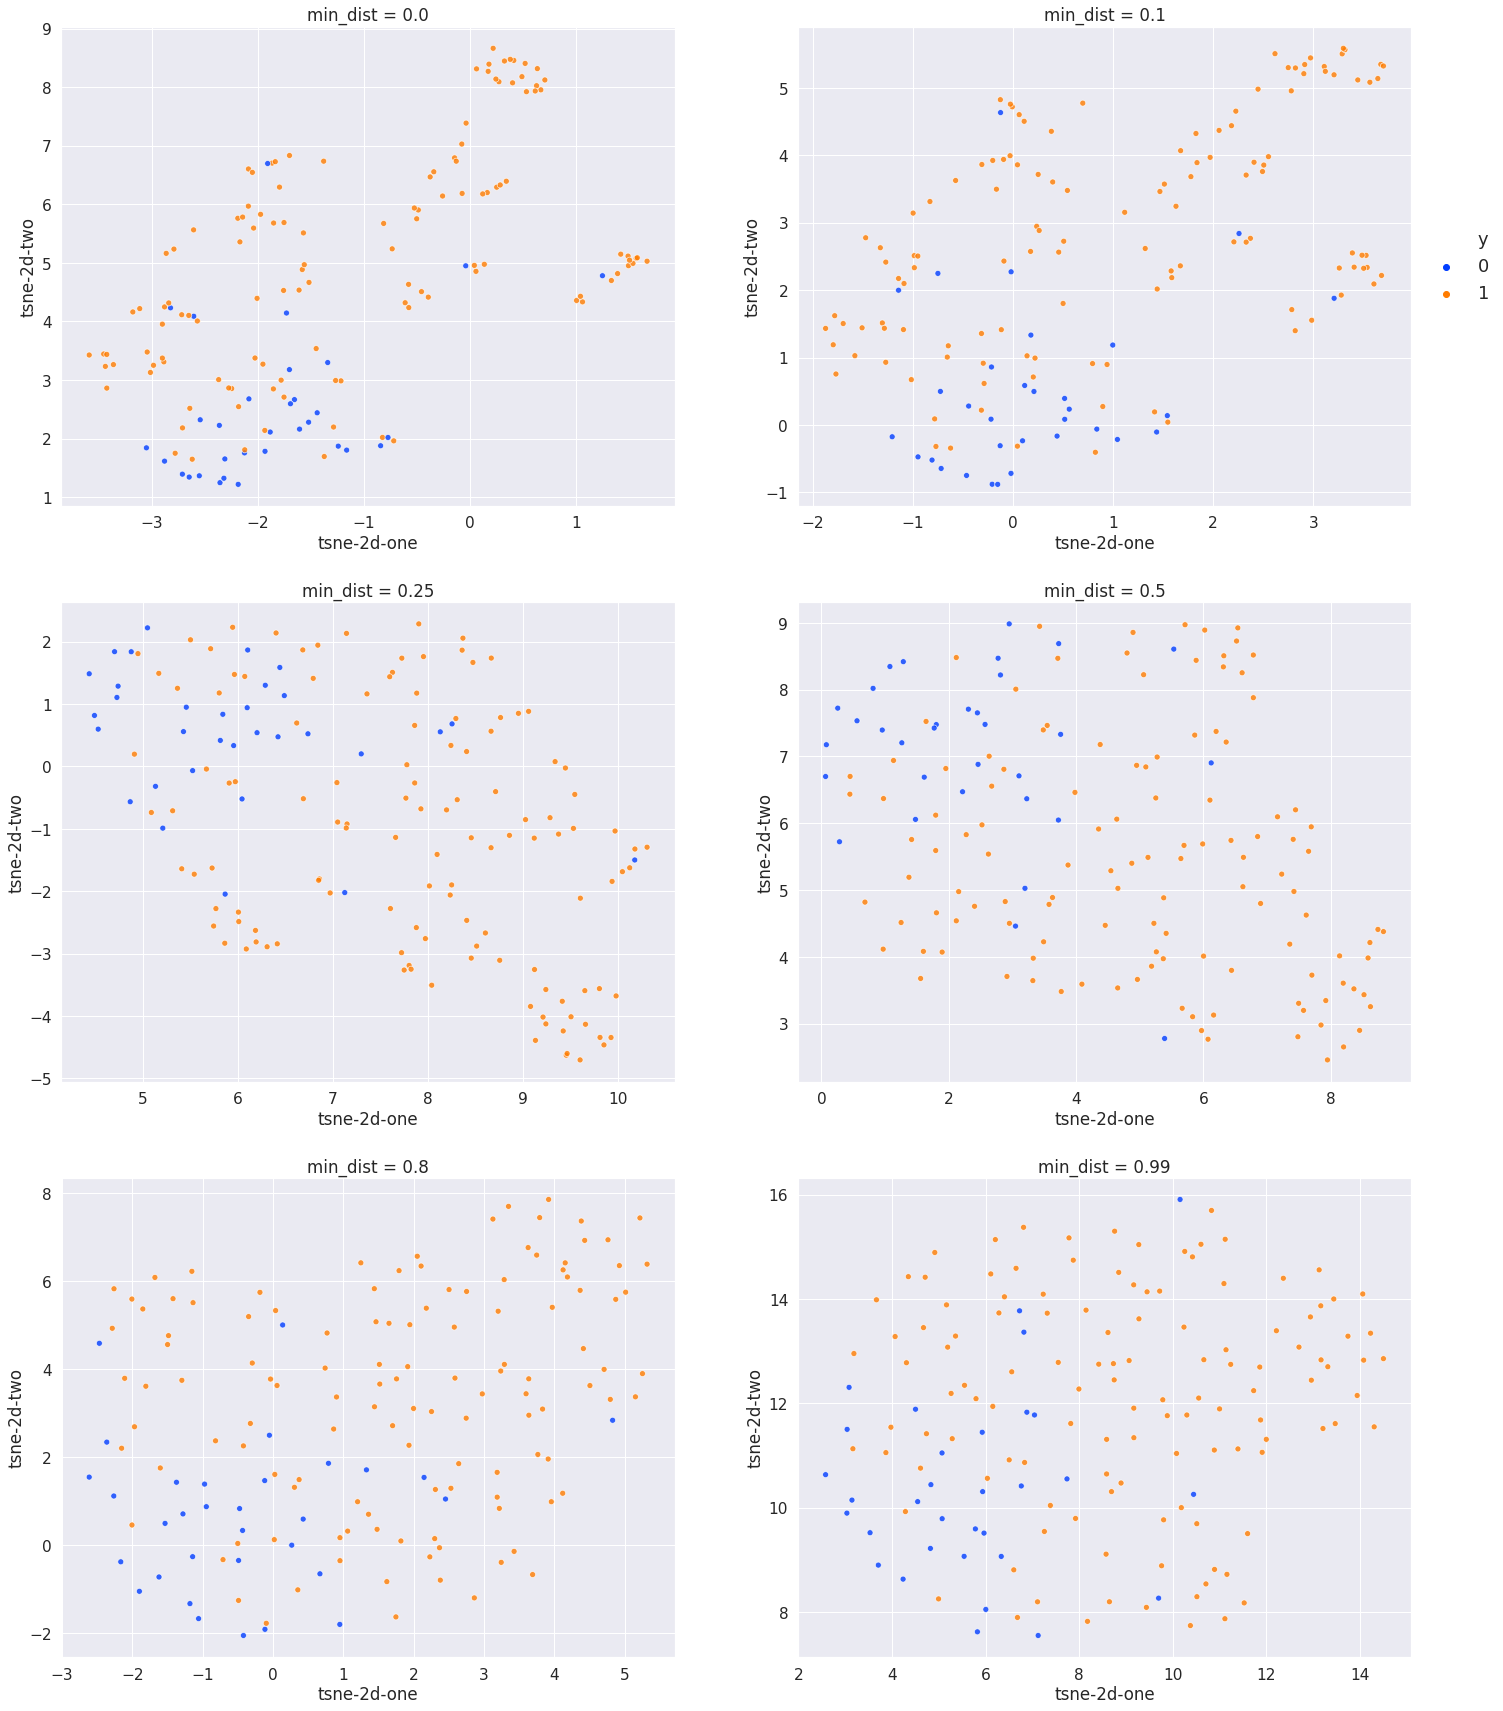

In [18]:
md = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
arr = []
for elem in md:
    x_embedded = umap.UMAP(n_components=2, min_dist=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("min_dist = 0.0")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("min_dist = 0.1")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("min_dist = 0.25")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("min_dist = 0.5")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("min_dist = 0.8")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("min_dist = 0.99")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Metric

/mnt/c/Users/User/My projects/Python/IMIZ/venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


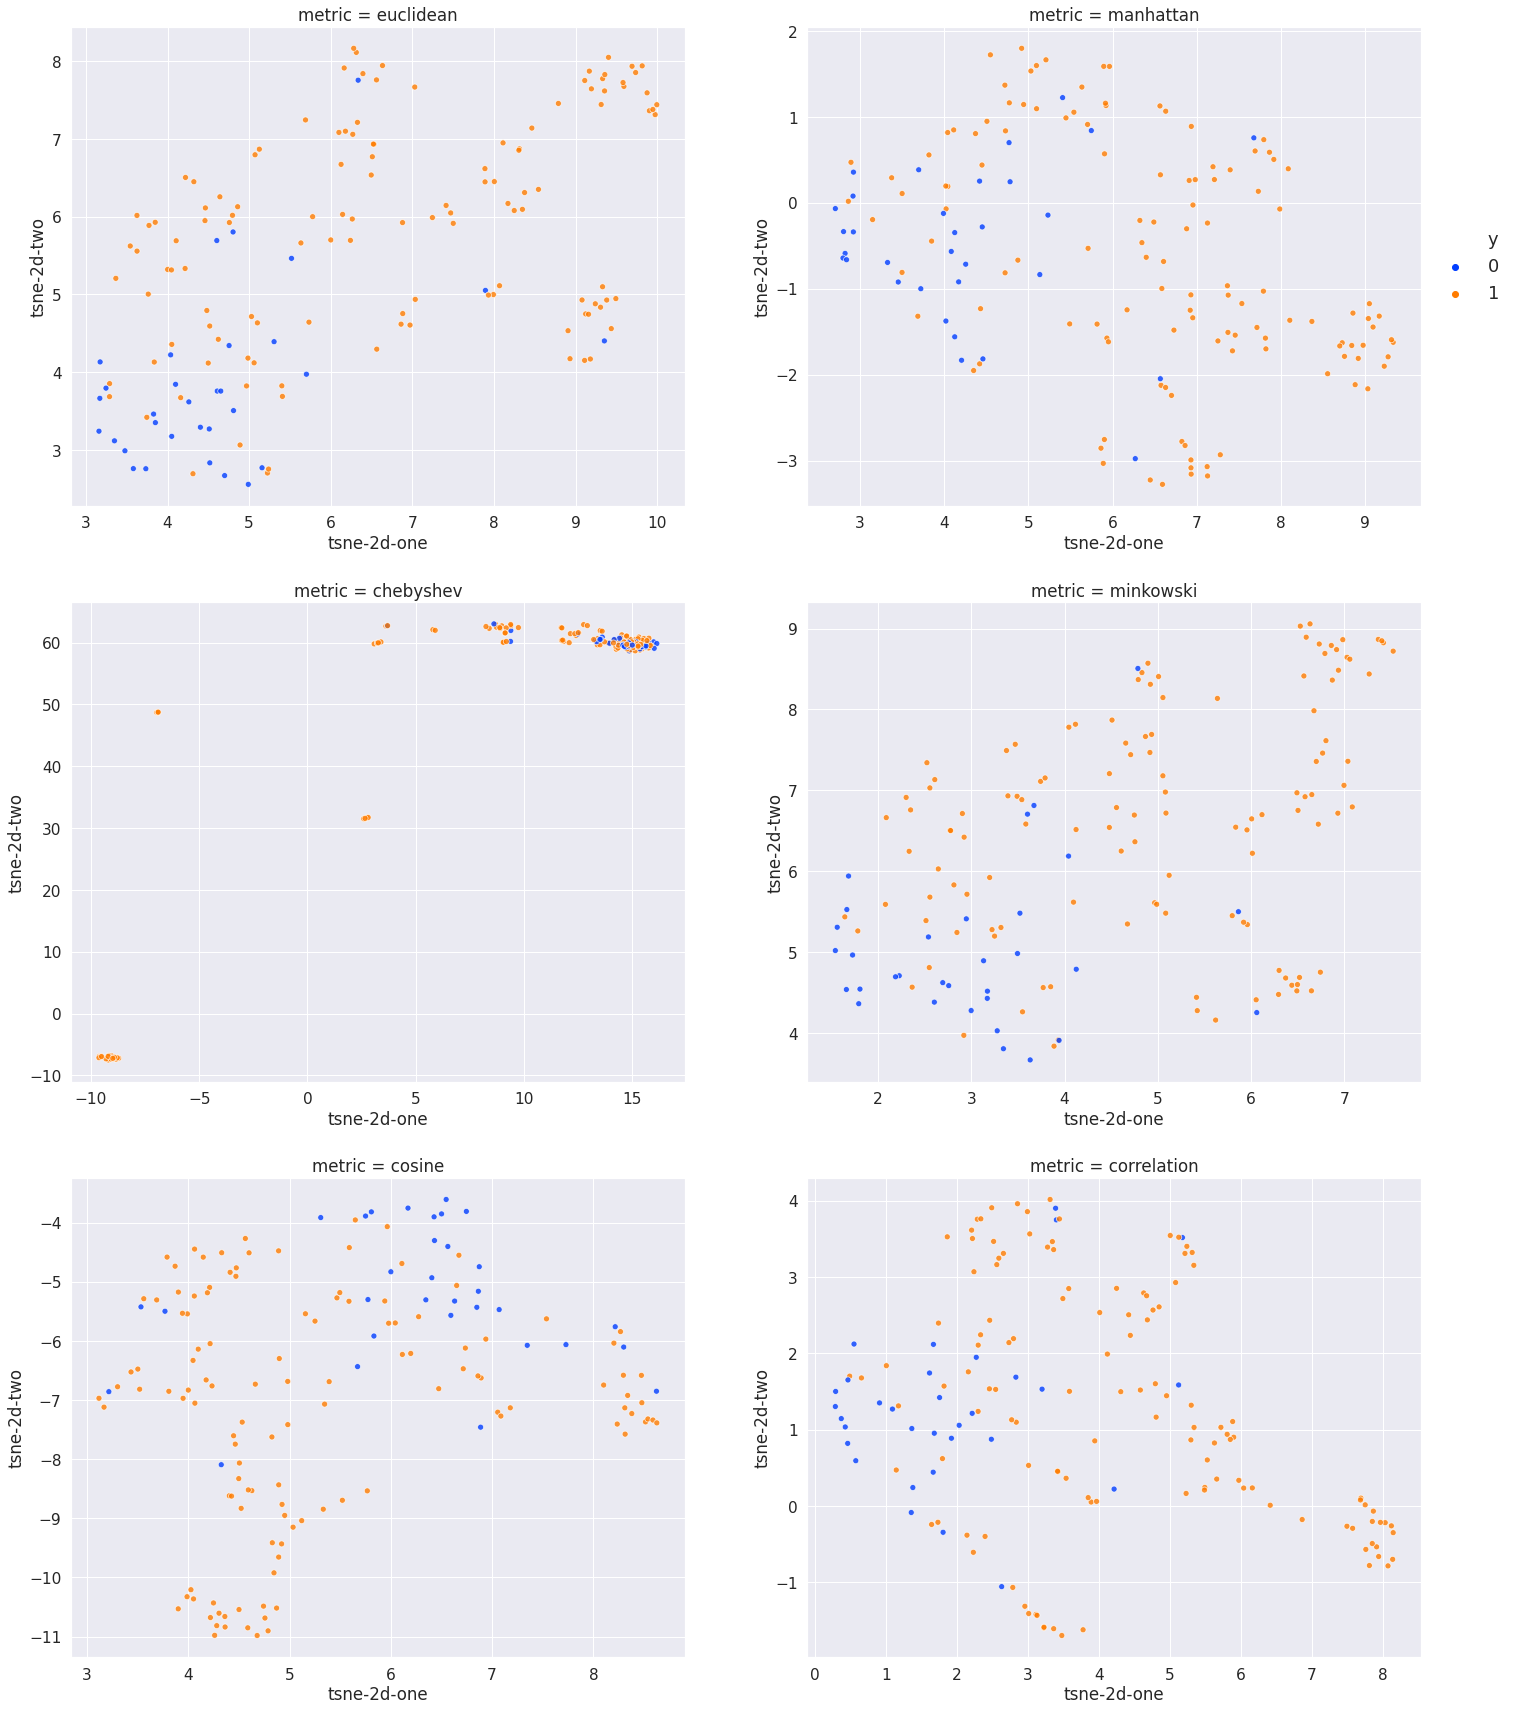

In [19]:
m = ['euclidean', 'manhattan', 'chebyshev',
     'minkowski', 'cosine', 'correlation']
arr = []
for elem in m:
    x_embedded = umap.UMAP(n_components=2, metric=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("metric = euclidean")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("metric = manhattan")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("metric = chebyshev")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("metric = minkowski")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("metric = cosine")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("metric = correlation")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Построение графика с комбинацией различных параметров алгоритма UMAP

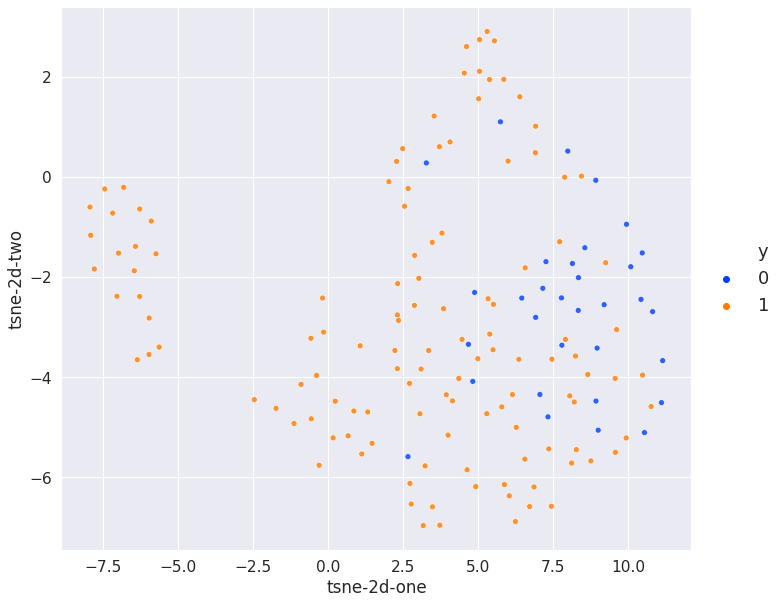

In [20]:
x_embedded = umap.UMAP(n_neighbors=5, min_dist=0.8,
                       metric='euclidean').fit_transform(x)
x_df = pd.DataFrame()
x_df['tsne-2d-one'] = x_embedded[:, 0]
x_df['tsne-2d-two'] = x_embedded[:, 1]
x_df['y'] = y

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="y", palette=sns.color_palette("bright", 2),
                data=x_df,
                legend="full", alpha=0.8)
plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)